# ABOUT THIS NOTEBOOK
## Purpose
This notebook analyzes the final machine learning models attempted on the data set.    
## Input
'data_set.pickle' generated by 'data_processing.ipynb'.
## Output
Results of residual analysis & sensitivity analysis.
## Tasks Performed
* Load library packages
* Load pickle file
* Split data into train & test sets
    * Train: weeks 1 & 2, Test: week 3
    * Perform feature scaling
* Implement classes & functions for common tasks
    * Perform the following sensitivity analyses:
        * 10 fold CV
        * Perturbation of input using random noise
    * Perform the following residual analyses:
        * Correlation matrix
        * Residual, Scatter plot
        * Facet plots
        * Feature importances using Random Forests
* Run the following algorithms:
    * Random Forest Regressor
    * Gradient Boosting Regressor
    * Neural Networks
    * Ensemble

# LOAD LIBRARY PACKAGES

In [2]:
# Import the required library packages
import os
import re
import timeit

import numpy as np  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.contrib.learn as skflow

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn import metrics
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

from six.moves import cPickle as pickle

# Settings for matplotlib, Seaborn
%matplotlib inline
sns.set_style('whitegrid')

# Set font sizes for matplots
plt.rcParams.update({'font.size': 15, 
                     'legend.fontsize': 'medium', 
                     'axes.titlesize': 'medium', 
                     'axes.labelsize': 'medium'})

print 'Read in packages from os, numpy, pandas, matplotlib, seaborn, tensorflow, sklearn & six'

 Read in packages from os, numpy, pandas, matplotlib, seaborn, tensorflow, sklearn & six


In [3]:
import sklearn as sk
print 'sklearn', sk.__version__
print 'pandas', pd.__version__
print 'numpy', np.__version__
print 'tensorflow', tf.__version__
print 'seaborn', sns.__version__

sklearn 0.17.1
pandas 0.18.0
numpy 1.11.1
tensorflow 0.9.0
seaborn 0.7.0


# LOAD PICKLE FILE

In [4]:
pickle_file = 'data_set.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    pdata_set = save['data_set']
    del save
    print 'Loaded ptrain_set', pdata_set.shape
    
f.close()

Loaded ptrain_set (199584, 55)


In [5]:
pdata_set.columns.values

array(['district_id', 'num_day', 'time_slot', 'week_day', 'demand',
       'demand_t-1', 'demand_t-2', 'demand_t-3', 'supply', 'supply_t-1',
       'supply_t-2', 'supply_t-3', 'gap', 'weather', 'temperature',
       'pollution', 'poi_pc1', 'poi_pc2', 'poi_pc3', 'poi_pc4',
       'poi_cluster', 'tj_lvl1', 'tj_lvl2', 'tj_lvl3', 'tj_lvl4', 'dist_0',
       'dist_1', 'dist_2', 'dist_3', 'dist_4', 'dist_5', 'dist_6',
       'numday_0', 'numday_1', 'numday_2', 'numday_3', 'numday_4', 'ts_0',
       'ts_1', 'ts_2', 'ts_3', 'ts_4', 'ts_5', 'ts_6', 'ts_7', 'weekday_0',
       'weekday_1', 'weekday_2', 'poi_0', 'poi_1', 'poi_2', 'wthr_0',
       'wthr_1', 'wthr_2', 'wthr_3'], dtype=object)

# ADD GAP FOR PREVIOUS TIME SLOTS

In [6]:
# Create new gap features for previous 3 time slots
pdata_set['gap_t-1'] = (pdata_set['demand_t-1'] - pdata_set['supply_t-1'])
pdata_set['gap_t-2'] = (pdata_set['demand_t-2'] - pdata_set['supply_t-2'])
pdata_set['gap_t-3'] = (pdata_set['demand_t-3'] - pdata_set['supply_t-3'])

# SPLIT DATA INTO TRAIN & TEST SETS

## Use weeks 1 & 2 for training, week 3 for test

In [7]:
train_days     = range(1,15)
test_days      = range(15, 22)

X_train     = pdata_set[(pdata_set['num_day'].isin(train_days))]
X_test      = pdata_set[(pdata_set['num_day'].isin(test_days))]

print "Shape of X_train, X_test:", X_train.shape, X_test.shape, "\n\n"

Shape of X_train, X_test: (133056, 58) (66528, 58) 




## Generate scaled features for train & test sets

In [8]:
import warnings
warnings.filterwarnings('ignore')

gap_predictors = ['demand_t-1', 'demand_t-2', 'demand_t-3',
                  'supply_t-1', 'supply_t-2', 'supply_t-3',
                  'poi_pc1', 'poi_pc2',
                  'tj_lvl1', 'tj_lvl2', 'tj_lvl3',
                  'ts_0', 'ts_1', 'ts_2', 'ts_3', 'ts_4', 'ts_5', 'ts_6', 'ts_7',
                  'pollution', 'temperature',
                  'wthr_0', 'wthr_1', 'wthr_2', 'wthr_3',
                  'gap_t-1', 'gap_t-2', 'gap_t-3',
                  'time_slot', 'week_day','district_id'
                 ]  

gX_train = []
gy_train = []
gX_test  = []
gy_test  = []

# Use StandardScaler to achieve zero mean and unit variance
# Generate two scalers: input and target
input_scaler = StandardScaler().fit(pdata_set[gap_predictors])
target_scaler = StandardScaler().fit(pdata_set['gap'])

# Scale both training & test data
gX_train  = input_scaler.transform(X_train[gap_predictors])
gy_train  = target_scaler.transform(X_train['gap'])

gX_test = input_scaler.transform(X_test[gap_predictors])
gy_test = target_scaler.transform(X_test['gap'])

In [9]:
X_train.columns.values

array(['district_id', 'num_day', 'time_slot', 'week_day', 'demand',
       'demand_t-1', 'demand_t-2', 'demand_t-3', 'supply', 'supply_t-1',
       'supply_t-2', 'supply_t-3', 'gap', 'weather', 'temperature',
       'pollution', 'poi_pc1', 'poi_pc2', 'poi_pc3', 'poi_pc4',
       'poi_cluster', 'tj_lvl1', 'tj_lvl2', 'tj_lvl3', 'tj_lvl4', 'dist_0',
       'dist_1', 'dist_2', 'dist_3', 'dist_4', 'dist_5', 'dist_6',
       'numday_0', 'numday_1', 'numday_2', 'numday_3', 'numday_4', 'ts_0',
       'ts_1', 'ts_2', 'ts_3', 'ts_4', 'ts_5', 'ts_6', 'ts_7', 'weekday_0',
       'weekday_1', 'weekday_2', 'poi_0', 'poi_1', 'poi_2', 'wthr_0',
       'wthr_1', 'wthr_2', 'wthr_3', 'gap_t-1', 'gap_t-2', 'gap_t-3'], dtype=object)

# SENSITIVITY ANALYSIS

## Implement classes & functions

In [10]:
class Sensitivity(object):
    '''Sensitivity analysis for attempted machine learning algorithms'''
    
    def __init__(self,alg,Xtrain,ytrain,Xtest,ytest):
        '''Fit the algorithm to train data, Create df with residual column'''
        self.regressor = alg
        self.X_train = Xtrain
        self.y_train = ytrain
        self.X_test = Xtest
        self.y_test = ytest
   
    def fit(self,X,y):
        '''Fit the algorithm to train data'''
        return(self.regressor.fit(X,y))
    
    def cross_validation_curve(self):
        '''Generate a simple plot of the cross validation curve for 10 iterations.'''
    
        # Cross validation with 10 iterations to get smoother mean test and train
        # score curves, each time with 20% data randomly selected as a validation set.
        cv = cross_validation.ShuffleSplit(self.X_train.shape[0], n_iter=10, test_size=0.2, random_state=0)
    
        start = timeit.default_timer()
        train_scores, test_scores = self.validation_curve(cv)
        self.train_scores = train_scores
        self.test_scores = test_scores
        stop = timeit.default_timer()
        h, m, s = self.conv_seconds(stop - start)
        print 'Cross-Validation Curves Runtime: {0:d}h:{1:02d}m:{2:02d}s\n\n' .format(h, m, s)

        train_scores_mean = np.mean(train_scores)
        train_scores_std = np.std(train_scores)
        test_scores_mean = np.mean(test_scores)
        test_scores_std = np.std(test_scores)
        
        iter_range = range(1,11)
        
        # Print Scores
        for iter_num, train_score, test_score in zip(iter_range, train_scores, test_scores):
            print ('Iter {0}: \tTrain Score: {1:.3f}\tCV Score: {2:.3f}' 
                   .format(iter_num, float(train_score), float(test_score)))
        print ('\t\tTrain Mean : {0:.3f}\tCV Mean : {1:.3f}' 
               .format(float(train_scores_mean), float(test_scores_mean)))
        print ('\t\tTrain Std  : {0:.3f}\tCV Std  : {1:.3f}' 
               .format(float(train_scores_std), float(test_scores_std)))
    
        plt.figure(figsize=(15,8))
        plt.title('Cross Validation Curve with 10 iterations')
        plt.ylabel('MSE')
        plt.xlabel('CV Iterations')
        plt.semilogx(iter_range, train_scores, label="Training score", color="r")
        plt.fill_between(iter_range, [train_scores_mean - train_scores_std]*10, 
                         [train_scores_mean + train_scores_std]*10, alpha=0.2, color="r")
        plt.semilogx(iter_range, test_scores, label="Cross-validation score", color="g")
        plt.fill_between(iter_range, [test_scores_mean - test_scores_std]*10, 
                         [test_scores_mean + test_scores_std]*10, 
                         alpha=0.2, color="g")
        plt.legend(loc="best")
        plt.show()
    
    def validation_curve(self, cv):
        '''Generate train and validation scores for provided hyperparameter range.'''
        
        train_pred_set = []
        cv_pred_set = []
        
        train_scores_set = []
        cv_scores_set = []
        
        X = self.X_train
        y = self.y_train
        
        # Fit and generate scores
        for train_index, cv_index in cv:
            self.fit(X[train_index], y[train_index])
    
            # Predict and score
            train_prediction = self.regressor.predict(X[train_index])
            train_pred_set.append(train_prediction)
            train_score = metrics.mean_squared_error(target_scaler.inverse_transform(train_prediction), 
                                                     target_scaler.inverse_transform(y[train_index]))
            train_scores_set.append(train_score)
        
            cv_prediction = self.regressor.predict(X[cv_index])
            cv_pred_set.append(cv_prediction)
            cv_score = metrics.mean_squared_error(target_scaler.inverse_transform(cv_prediction), 
                                                  target_scaler.inverse_transform(y[cv_index]))
            cv_scores_set.append(cv_score)
        
        self.train_pred_set = train_pred_set
        self.cv_pred_set = cv_pred_set
        
        return(train_scores_set,cv_scores_set)
    
    def conv_seconds(self, seconds):
        ''' Convert seconds to hours, minutes, seconds format.'''
        m, s = divmod(seconds, 60)
        h, m = divmod(m, 60)
        return (int(h),int(m),int(s))
    
    def scores_with_noise(self):
        '''Generate scores before and after adding noise'''
        Xtrain = self.X_train
        ytrain = self.y_train
        Xtest  = self.X_test
        
        print 'SCORES BEFORE ADDING NOISE'
        print '--------------------------'
        # Fit
        self.fit(Xtrain, ytrain)

        # Predict
        self.train_pred = target_scaler.inverse_transform(self.regressor.predict(Xtrain))
        self.test_pred  = target_scaler.inverse_transform(self.regressor.predict(Xtest))

        # Score
        self.print_score(X_train['gap'], self.train_pred, X_test['gap'], self.test_pred)
        
        print '\nSCORES AFTER ADDING NOISE'
        print '-------------------------'
        # Fit
        self.fit(self.add_noise(Xtrain), ytrain)

        # Predict
        self.train_pred_noise = target_scaler.inverse_transform(self.regressor.predict(Xtrain))
        self.test_pred_noise  = target_scaler.inverse_transform(self.regressor.predict(Xtest))

        # Score
        self.print_score(X_train['gap'], self.train_pred_noise, X_test['gap'], self.test_pred_noise)
        
    
    def add_noise(self,X):
        '''Add random noise to passed matrix'''
        print '\nAdded random normal noise with mean=0.0, std=0.25'
        noise = np.random.normal(0, 0.25, X.shape[0]*X.shape[1])
        X_with_noise = X + np.reshape(noise, (X.shape[0], X.shape[1]))
        return(X_with_noise)
    
    def print_score(self, y_train, y_pred_train, y_test, y_pred_test):
    
        """
        Present the MSE, R^2 and MAPE scores for train & test sets as a table.

        Parameters
        ----------
        y_train      : Array containing expected values for train set
        y_pred_train : Array containing predicted values for train set
        y_test       : Array containing expected values for test set
        y_pred_test  : Array containing predicted values for test set
        """
    
        m2score_train    = metrics.mean_squared_error(y_train,    y_pred_train)
        m2score_test     = metrics.mean_squared_error(y_test,     y_pred_test)


        r2score_train    = metrics.r2_score(y_train,    y_pred_train)
        r2score_test     = metrics.r2_score(y_test,     y_pred_test)

        # Assumes data is for 144 time slots, 14 days (train), 7 days (test)
        mpscore_train    = self.mape_score(y_train,    y_pred_train, ((144*14)-1))
        mpscore_test     = self.mape_score(y_test,     y_pred_test, ((144*7)-1))


        sets_list = ["TRAIN", "TEST"]
        m2_scores = [m2score_train, m2score_test]
        r2_scores = [r2score_train, r2score_test]
        mp_scores = [mpscore_train, mpscore_test]
        print '\t\tMEAN^2\t\tR2\t\tMAPE'
    
        for s, m, r, mp in zip(sets_list, m2_scores, r2_scores, mp_scores):
            print '{0:10}\t{1:.3f}\t\t{2:.3f}\t\t{3:.3f}' .format(s, m, r, mp)


    def mape_score(self, exp, pred, q):
    
        """
        Generate the MAPE score value.

        Parameters
        ----------
        exp  : Array containing expected values
        pred : Array containing predicted values
        q    : Constant representing (number of days * number of time slots) - 1
        """
    
        mape = 0.0
        n = 66.0
    
        for gap, gapX in zip(exp, pred):
            if gap > 0:
                mape += 1.0 * abs((gap-gapX)/gap)
        return (mape/(n*q))

In [11]:
class Sensitivitynn(Sensitivity):
    '''Sensitivity analysis for neural nets'''
    
    def __init__(self,alg,Xtrain,ytrain,Xtest,ytest,steps,batch_size):
        '''Make steps, batch_size available to the class'''
        self.steps = steps
        self.batch_size = batch_size
        super(Sensitivitynn,self).__init__(alg,Xtrain,ytrain,Xtest,ytest)
        
    def fit(self,X,y):
        '''Fit the algorithm to train data'''
        return(self.regressor.fit(X,y,steps=self.steps,batch_size=self.batch_size))

In [37]:
class Sensitivityen(Sensitivity):
    '''Sensitivity analysis for ensemble'''
    
    def __init__(self, Xtrain, ytrain, train_prediction, test_prediction, train_prediction_noise, test_prediction_noise):
        '''Create dataframe with residual column'''   
        self.X_train = Xtrain
        self.y_train = ytrain
        self.train_pred = train_prediction
        self.test_pred = test_prediction
        self.train_pred_noise = train_prediction_noise
        self.test_pred_noise = test_prediction_noise
        
    def scores_with_noise(self):
        '''Generate scores before and after adding noise'''
        print 'SCORES BEFORE ADDING NOISE'
        print '--------------------------' 
        self.print_score(X_train['gap'], self.train_pred, X_test['gap'], self.test_pred)
        
        print '\nSCORES AFTER ADDING NOISE'
        print '-------------------------'
        self.print_score(X_train['gap'], self.train_pred_noise, X_test['gap'], self.test_pred_noise)
        
    def cross_validation_curve(self, train_predictions, cv_predictions):
        '''Generate a simple plot of the cross validation curve for 10 iterations.'''
        
        # Cross validation with 10 iterations to get smoother mean test and train
        # score curves, each time with 20% data randomly selected as a validation set.
        cv = cross_validation.ShuffleSplit(self.X_train.shape[0], n_iter=10, test_size=0.2, random_state=0)
        
        train_indices = []
        cv_indices = []
        for i, j in cv:
            train_indices.append(i)
            cv_indices.append(j)
        
        train_scores = []
        test_scores = []
        
        X = self.X_train
        y = self.y_train
                
        # Generate scores
        for train_index, cv_index, train_prediction, cv_prediction in zip(train_indices, cv_indices, train_predictions, cv_predictions):

            train_score = metrics.mean_squared_error(target_scaler.inverse_transform(train_prediction), 
                                                     target_scaler.inverse_transform(y[train_index]))
            train_scores.append(train_score)
        
            cv_score = metrics.mean_squared_error(target_scaler.inverse_transform(cv_prediction), 
                                                  target_scaler.inverse_transform(y[cv_index]))
            test_scores.append(cv_score)
    
        train_scores_mean = np.mean(train_scores)
        train_scores_std = np.std(train_scores)
        test_scores_mean = np.mean(test_scores)
        test_scores_std = np.std(test_scores)
        
        iter_range = range(1,11)
        
        # Print Scores
        for iter_num, train_score, test_score in zip(iter_range, train_scores, test_scores):
            print ('Iter {0}: \tTrain Score: {1:.3f}\tCV Score: {2:.3f}' 
                   .format(iter_num, float(train_score), float(test_score)))
        print ('\t\tTrain Mean : {0:.3f}\tCV Mean : {1:.3f}' 
               .format(float(train_scores_mean), float(test_scores_mean)))
        print ('\t\tTrain Std  : {0:.3f}\tCV Std  : {1:.3f}' 
               .format(float(train_scores_std), float(test_scores_std)))
    
        plt.figure(figsize=(15,8))
        plt.title('Cross Validation Curve with 10 iterations')
        plt.ylabel('MSE')
        plt.xlabel('CV Iterations')
        plt.semilogx(iter_range, train_scores, label="Training score", color="r")
        plt.fill_between(iter_range, [train_scores_mean - train_scores_std]*10, 
                         [train_scores_mean + train_scores_std]*10, alpha=0.2, color="r")
        plt.semilogx(iter_range, test_scores, label="Cross-validation score", color="g")
        plt.fill_between(iter_range, [test_scores_mean - test_scores_std]*10, 
                         [test_scores_mean + test_scores_std]*10, 
                         alpha=0.2, color="g")
        plt.legend(loc="best")
        plt.show()

## RANDOM FORESTS

Cross-Validation Curves Runtime: 0h:00m:36s


Iter 1: 	Train Score: 135.306	CV Score: 175.949
Iter 2: 	Train Score: 122.664	CV Score: 205.154
Iter 3: 	Train Score: 150.051	CV Score: 608.427
Iter 4: 	Train Score: 136.979	CV Score: 155.471
Iter 5: 	Train Score: 149.421	CV Score: 365.955
Iter 6: 	Train Score: 139.145	CV Score: 148.441
Iter 7: 	Train Score: 140.263	CV Score: 344.925
Iter 8: 	Train Score: 136.834	CV Score: 335.985
Iter 9: 	Train Score: 144.810	CV Score: 193.890
Iter 10: 	Train Score: 131.135	CV Score: 239.693
		Train Mean : 138.661	CV Mean : 277.389
		Train Std  : 7.849	CV Std  : 134.468


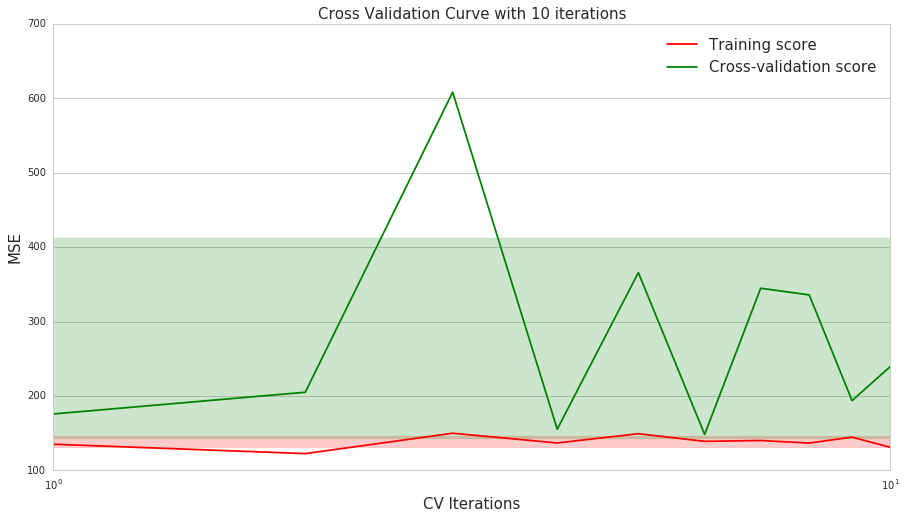

SCORES BEFORE ADDING NOISE
--------------------------
		MEAN^2		R2		MAPE
TRAIN     	126.596		0.934		0.329
TEST      	274.642		0.881		0.338

SCORES AFTER ADDING NOISE
-------------------------

Added random normal noise with mean=0.0, std=0.25
		MEAN^2		R2		MAPE
TRAIN     	178.030		0.907		0.311
TEST      	299.227		0.871		0.311


In [13]:
rf_predictors = [0,1,6,7,25,26,27,28]

regressor = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=11, max_features=1.0, max_leaf_nodes=None, 
                                  min_samples_leaf=5, min_samples_split=15, min_weight_fraction_leaf=0.0, 
                                  n_estimators=300, n_jobs=-1, oob_score=False, random_state=0, verbose=0, 
                                  warm_start=False)

rf_sensitivity = Sensitivity(regressor, gX_train[:, rf_predictors], gy_train, gX_test[:, rf_predictors], gy_test)
rf_sensitivity.cross_validation_curve()
rf_sensitivity.scores_with_noise()

## GRADIENT BOOSTED TREES

Cross-Validation Curves Runtime: 0h:03m:29s


Iter 1: 	Train Score: 36.556	CV Score: 117.377
Iter 2: 	Train Score: 35.282	CV Score: 152.102
Iter 3: 	Train Score: 38.778	CV Score: 219.858
Iter 4: 	Train Score: 36.412	CV Score: 129.201
Iter 5: 	Train Score: 35.995	CV Score: 269.784
Iter 6: 	Train Score: 37.833	CV Score: 125.855
Iter 7: 	Train Score: 36.230	CV Score: 170.539
Iter 8: 	Train Score: 36.894	CV Score: 145.843
Iter 9: 	Train Score: 36.165	CV Score: 141.214
Iter 10: 	Train Score: 35.150	CV Score: 162.495
		Train Mean : 36.530	CV Mean : 163.427
		Train Std  : 1.042	CV Std  : 44.925


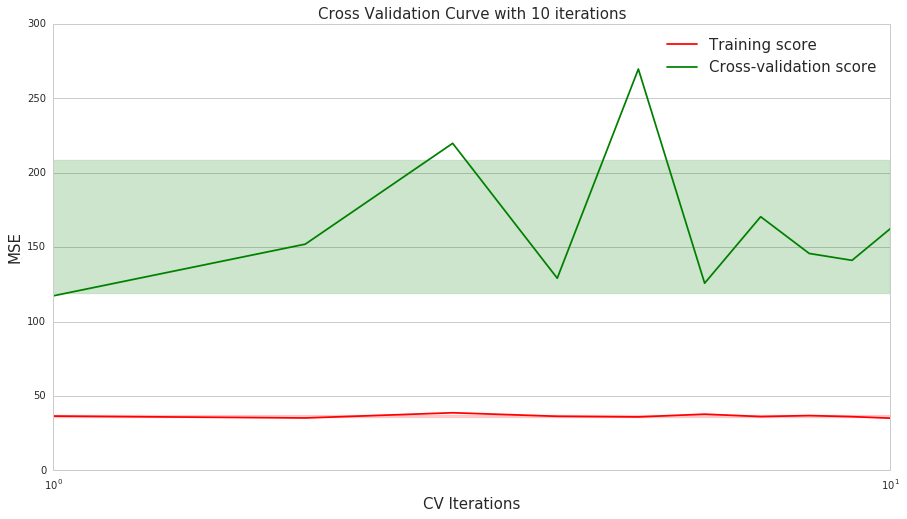

SCORES BEFORE ADDING NOISE
--------------------------
		MEAN^2		R2		MAPE
TRAIN     	40.489		0.979		0.334
TEST      	247.615		0.893		0.339

SCORES AFTER ADDING NOISE
-------------------------

Added random normal noise with mean=0.0, std=0.25
		MEAN^2		R2		MAPE
TRAIN     	113.987		0.940		0.358
TEST      	307.569		0.867		0.356


In [14]:
gbr_predictors = [0,1,2,8,9,10,25,26,27,28,29,30]

regressor = GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',max_depth=5, max_features=None, 
                                      max_leaf_nodes=None, min_samples_leaf=3, min_samples_split=6, 
                                      min_weight_fraction_leaf=0.0, n_estimators=200, presort='auto', random_state=None, 
                                      subsample=1.0, verbose=0, warm_start=False)

gbr_sensitivity = Sensitivity(regressor, gX_train[:, gbr_predictors], gy_train, gX_test[:, gbr_predictors], gy_test)
gbr_sensitivity.cross_validation_curve()
gbr_sensitivity.scores_with_noise()

## NEURAL NETS

Cross-Validation Curves Runtime: 0h:02m:32s


Iter 1: 	Train Score: 159.328	CV Score: 141.838
Iter 2: 	Train Score: 155.658	CV Score: 156.516
Iter 3: 	Train Score: 155.392	CV Score: 157.582
Iter 4: 	Train Score: 156.641	CV Score: 152.585
Iter 5: 	Train Score: 155.389	CV Score: 157.592
Iter 6: 	Train Score: 156.151	CV Score: 154.544
Iter 7: 	Train Score: 158.040	CV Score: 146.989
Iter 8: 	Train Score: 152.942	CV Score: 167.378
Iter 9: 	Train Score: 154.925	CV Score: 159.450
Iter 10: 	Train Score: 149.335	CV Score: 181.809
		Train Mean : 155.380	CV Mean : 157.628
		Train Std  : 2.600	CV Std  : 10.401


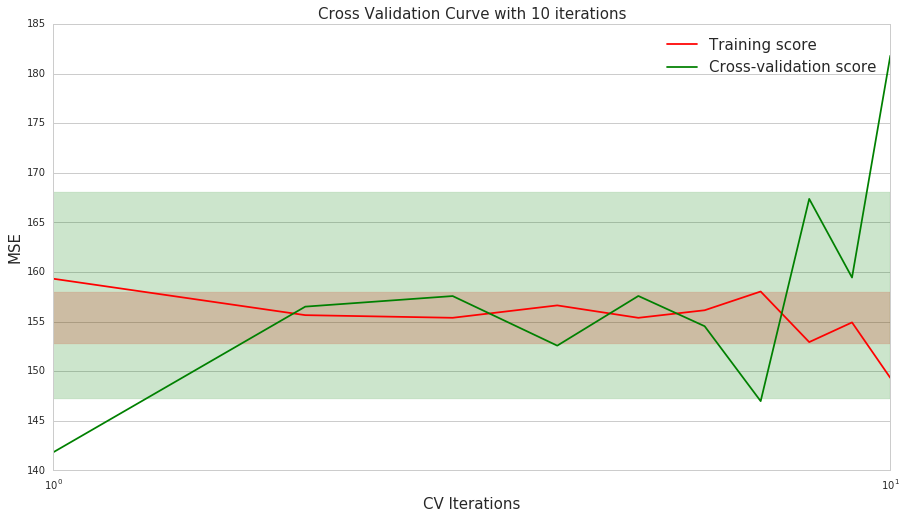

SCORES BEFORE ADDING NOISE
--------------------------
		MEAN^2		R2		MAPE
TRAIN     	155.830		0.918		0.376
TEST      	300.014		0.870		0.361

SCORES AFTER ADDING NOISE
-------------------------

Added random normal noise with mean=0.0, std=0.25
		MEAN^2		R2		MAPE
TRAIN     	155.830		0.918		0.376
TEST      	300.014		0.870		0.361


In [15]:
nn_predictors = [0,1,2,6,7,8,9,10,25,26,28,29]

# Set up optimizer, regressor
learning_rate=0.03 
hidden_units=[12, 12, 12] 
dropout=0.01 
steps=10000 
batch_size=3000

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
regressor = skflow.DNNRegressor(hidden_units=hidden_units, optimizer=optimizer, dropout=float(dropout))

nn_sensitivity = Sensitivitynn(regressor, gX_train[:, nn_predictors], gy_train, gX_test[:, nn_predictors], gy_test, 
                               steps, batch_size)
nn_sensitivity.cross_validation_curve()
nn_sensitivity.scores_with_noise()

## ENSEMBLE

Iter 1: 	Train Score: 84.427	CV Score: 124.198
Iter 2: 	Train Score: 80.821	CV Score: 153.830
Iter 3: 	Train Score: 85.834	CV Score: 250.592
Iter 4: 	Train Score: 83.375	CV Score: 135.363
Iter 5: 	Train Score: 84.584	CV Score: 217.720
Iter 6: 	Train Score: 84.994	CV Score: 132.653
Iter 7: 	Train Score: 84.306	CV Score: 175.589
Iter 8: 	Train Score: 82.957	CV Score: 181.822
Iter 9: 	Train Score: 85.278	CV Score: 146.508
Iter 10: 	Train Score: 80.283	CV Score: 174.681
		Train Mean : 83.686	CV Mean : 169.295
		Train Std  : 1.761	CV Std  : 38.034


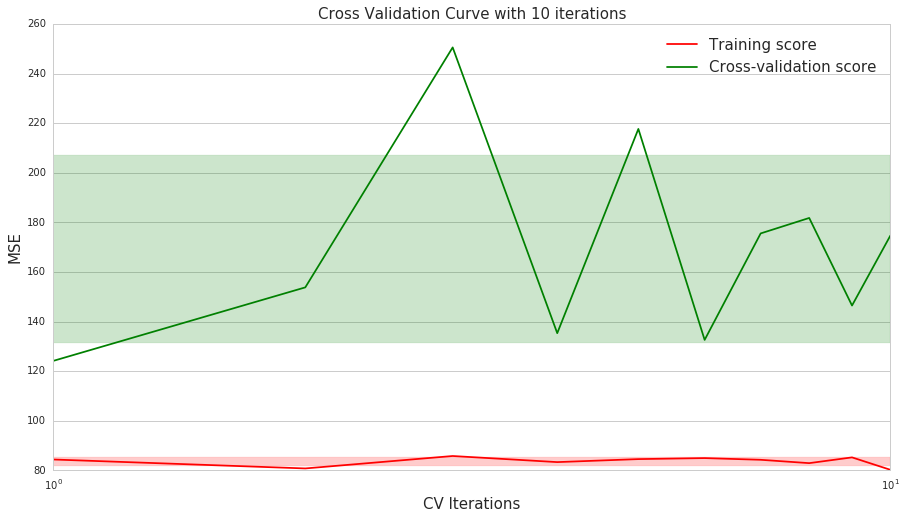

SCORES BEFORE ADDING NOISE
--------------------------
		MEAN^2		R2		MAPE
TRAIN     	84.435		0.956		0.333
TEST      	254.161		0.890		0.331

SCORES AFTER ADDING NOISE
-------------------------
		MEAN^2		R2		MAPE
TRAIN     	131.114		0.931		0.325
TEST      	284.346		0.877		0.319


In [38]:
# Calculate ensemble predictions for cross validation
rf_trainpredset  = rf_sensitivity.train_pred_set
gbr_trainpredset = gbr_sensitivity.train_pred_set
nn_trainpredset  = nn_sensitivity.train_pred_set
train_pred_set = []
for i in range(0,10):
    train_pred_set.append((rf_trainpredset[i] + gbr_trainpredset[i] + nn_trainpredset[i]) / 3.0)

rf_cvpredset  = rf_sensitivity.cv_pred_set
gbr_cvpredset = gbr_sensitivity.cv_pred_set
nn_cvpredset  = nn_sensitivity.cv_pred_set
cv_pred_set = []
for i in range(0,10):
    cv_pred_set.append((rf_cvpredset[i] + gbr_cvpredset[i] + nn_cvpredset[i]) / 3.0)


# Calculate ensemble predictions without noise
rf_trainpred  = rf_sensitivity.train_pred
gbr_trainpred = gbr_sensitivity.train_pred
nn_trainpred  = nn_sensitivity.train_pred
train_prediction = (rf_trainpred + gbr_trainpred + nn_trainpred) / 3.0

rf_testpred  = rf_sensitivity.test_pred
gbr_testpred = gbr_sensitivity.test_pred
nn_testpred  = nn_sensitivity.test_pred
test_prediction = (rf_testpred + gbr_testpred + nn_testpred) / 3.0

# Calculate ensemble predictions with noise
rf_trainpred  = rf_sensitivity.train_pred_noise
gbr_trainpred = gbr_sensitivity.train_pred_noise
nn_trainpred  = nn_sensitivity.train_pred_noise
train_prediction_noise = (rf_trainpred + gbr_trainpred + nn_trainpred) / 3.0

rf_testpred  = rf_sensitivity.test_pred_noise
gbr_testpred = gbr_sensitivity.test_pred_noise
nn_testpred  = nn_sensitivity.test_pred_noise
test_prediction_noise = (rf_testpred + gbr_testpred + nn_testpred) / 3.0

# Create an instance, call the methods
en_sensitivity = Sensitivityen(gX_train, gy_train, train_prediction, test_prediction, train_prediction_noise, 
                               test_prediction_noise)
en_sensitivity.cross_validation_curve(train_pred_set, cv_pred_set)
en_sensitivity.scores_with_noise()

## FREE FORM VISUALIZATIONS (Scatter Plots for Train & Test Data)

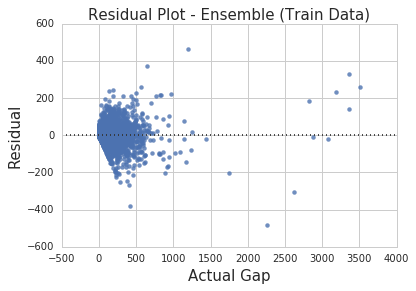

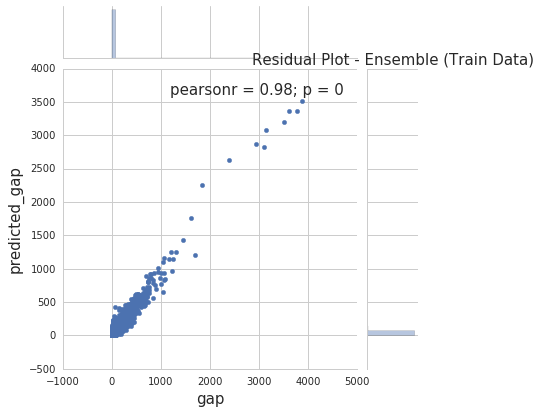

In [43]:
df = X_train.copy()
df['predicted_gap'] = train_prediction
ax= sns.residplot(df['predicted_gap'], df['gap'])
ax.set(xlabel='Actual Gap', ylabel='Residual')
sns.plt.title('Residual Plot - Ensemble (Train Data)')
plt.show()
        
sns.jointplot(df['gap'],df['predicted_gap'])
sns.plt.title('Residual Plot - Ensemble (Train Data)')
plt.show()

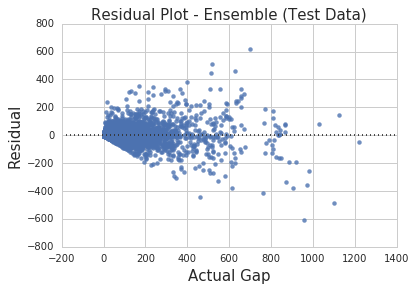

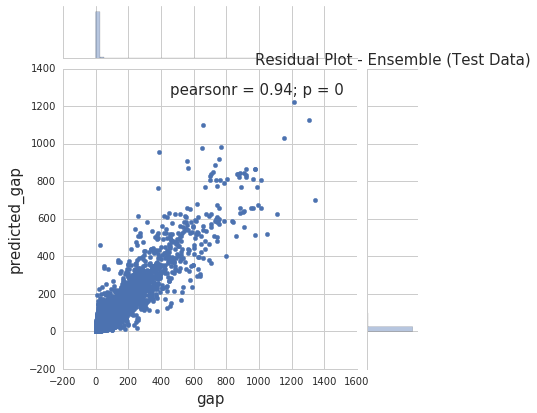

In [41]:
df = X_test.copy()
df['predicted_gap'] = test_prediction
ax= sns.residplot(df['predicted_gap'], df['gap'])
ax.set(xlabel='Actual Gap', ylabel='Residual')
sns.plt.title('Residual Plot - Ensemble (Test Data)')
plt.show()
        
sns.jointplot(df['gap'],df['predicted_gap'])
sns.plt.title('Residual Plot - Ensemble (Test Data)')
plt.show()

# RESIDUAL ANALYSIS

## Implement classes & functions

In [8]:
class ResidualPlot(object):
    '''Residual analysis for attempted machine learning algorithms'''
    
    def __init__(self,alg,X,y):
        '''Fit the algorithm to train data, Create df with residual column'''
        self.reg = self.fit(alg,X,y)
        print 'Successfully fit the algorithm to train data.'
        
        self.pred_train = target_scaler.inverse_transform(self.reg.predict(X))
        self.error_train = X_train['gap'] - self.pred_train
        print 'Generated predictions and errors for train data.'
        
        self.residual_df = X_train.copy()
        self.residual_df['predicted_gap'] = self.pred_train
        self.residual_df['residual'] = self.error_train
        print 'Created dataframe with residual column.\n'
   
    def fit(self,alg,X,y):
        '''Fit the algorithm to train data'''
        return(alg.fit(X,y))
    
    def generate_corrmatrix(self):
        '''Generate correlation matrix with residual data'''
        print 'CORRELATION MATRIX - RESIDUAL vs FEATURES'
        print self.residual_df.corr()['residual']
      
    def generate_resplot(self):
        '''Generate residual & scatter plot'''
        ax= sns.residplot(self.residual_df['predicted_gap'], self.residual_df['gap'])
        ax.set(xlabel='Actual Gap', ylabel='Residual')
        sns.plt.title('Residual Plot')
        plt.show()
        
        sns.jointplot(self.residual_df['gap'],self.residual_df['predicted_gap'])
        plt.show()
          
    def generate_facetplots(self):
        '''Generate facet plots'''
        pdata_set = self.residual_df
        self.plot_set = pdata_set[(pdata_set['district_id'].isin([12, 19, 23]))]
        self._facetplot_gap()
        self._facetplot_time()
        self._facetplot_demand()
        self._facetplot_supply()
        self._facetplot_traffic()
        
    def _facetplot_gap(self):
        g = sns.FacetGrid(self.plot_set, col='district_id')
        g.map(plt.scatter, 'gap', 'residual')
        plt.subplots_adjust(top=0.8)
        g.fig.suptitle('Facet Plot - Gap vs Residual')
        plt.show()
    
    def _facetplot_time(self):
        g = sns.FacetGrid(self.plot_set, col='district_id')
        g.map(plt.scatter, 'time_slot', 'residual')
        plt.subplots_adjust(top=0.8)
        g.fig.suptitle('Facet Plot - Time vs Residual')
        plt.show()
        
    def _facetplot_demand(self):
        g = sns.FacetGrid(self.plot_set, col='district_id')
        g.map(plt.scatter, 'demand_t-1', 'residual')
        plt.subplots_adjust(top=0.8)
        g.fig.suptitle('Facet Plot - Demand vs Residual')
        plt.show()
 
    def _facetplot_supply(self):
        g = sns.FacetGrid(self.plot_set, col='district_id')
        g.map(plt.scatter, 'supply_t-1', 'residual')
        plt.subplots_adjust(top=0.8)
        g.fig.suptitle('Facet Plot - Supply vs Residual')
        plt.show()
        
    def _facetplot_traffic(self):
        g = sns.FacetGrid(self.plot_set, col='district_id')
        g.map(plt.scatter, 'tj_lvl3', 'residual')
        plt.subplots_adjust(top=0.8)
        g.fig.suptitle('Facet Plot - Traffic vs Residual')
        plt.show()
    
    def feature_importances(self):
        '''Use random forest feature importances to find features that may influence residual error'''
    
        predictors = ['dist_0', 'dist_1', 'dist_2', 'dist_3', 'dist_4', 'dist_5', 'dist_6',
                      'wthr_0', 'wthr_1', 'wthr_2', 'wthr_3', 
                      'poi_pc2', 'poi_pc3', 'poi_pc4',
                      'numday_0', 'numday_1', 'numday_2', 'numday_3', 'numday_4', 
                      'weekday_0', 'weekday_1', 'weekday_2',
                      'time_slot', 'week_day'
                     ] 

        # Input Samples and Target Values
        X = self.residual_df[predictors]
        y = self.residual_df['residual']

        # Fit Random Forest Regressor
        # Large n_estimators, small max_depth to avoid overfitting
        alg = RandomForestRegressor(n_jobs=-1, random_state=1, n_estimators=1000, max_depth=20)
        rfr = alg.fit(X, y)

        # Feature importances
        importances = rfr.feature_importances_
        indices = np.argsort(importances)[::-1]
        feature_labels = predictors
    
        print 'FEATURE IMPORTANCES - RESIDUAL vs SELECT FEATURES'
        for f in range(X.shape[1]):
            print("%2d) %-*s %f" % (f + 1, 30, 
                                    feature_labels[indices[f]], 
                                    importances[indices[f]]))

        labels_reordered = [feature_labels[i] for i in indices]
    
        plt.title('Residual Feature Importances')
        plt.bar(range(X.shape[1]), importances[indices], color='lightblue', align='center')
        plt.xticks(range(X.shape[1]), labels_reordered, rotation=90)
        plt.xlim([-1, X.shape[1]])
        plt.tight_layout()
        plt.show()

In [9]:
class ResidualPlotnn(ResidualPlot):
    '''Residual analysis for neural nets'''
    
    def __init__(self,alg,X,y,steps,batch_size):
        '''Make steps, batch_size available to the class'''
        self.steps = steps
        self.batch_size = batch_size
        super(ResidualPlotnn,self).__init__(alg,X,y)

        
    def fit(self,alg,X,y):
        '''Fit the algorithm to train data'''
        return(alg.fit(X,y,steps=self.steps,batch_size=self.batch_size))

In [10]:
class ResidualPloten(ResidualPlot):
    '''Residual analysis for ensemble'''
    
    def __init__(self, train_prediction):
        '''Create dataframe with residual column'''       
        self.pred_train = train_prediction
        self.error_train = X_train['gap'] - self.pred_train
        print 'Generated predictions and errors for train data.'
        
        self.residual_df = X_train.copy()
        self.residual_df['predicted_gap'] = self.pred_train
        self.residual_df['residual'] = self.error_train
        print 'Created dataframe with residual column.\n'

## RANDOM FORESTS

Successfully fit the algorithm to train data.
Generated predictions and errors for train data.
Created dataframe with residual column.

CORRELATION MATRIX - RESIDUAL vs FEATURES
district_id     -0.002703
num_day         -0.009961
time_slot       -0.003109
week_day        -0.002886
demand           0.173501
demand_t-1       0.051780
demand_t-2       0.016234
demand_t-3      -0.007202
supply           0.013084
supply_t-1       0.017755
supply_t-2       0.014431
supply_t-3       0.017592
gap              0.366429
weather          0.003631
temperature      0.001302
pollution        0.008044
poi_pc1         -0.008920
poi_pc2          0.008554
poi_pc3          0.003808
poi_pc4          0.002670
poi_cluster      0.001243
tj_lvl1          0.005341
tj_lvl2          0.008727
tj_lvl3          0.014082
tj_lvl4          0.015819
gap_t-1          0.086344
gap_t-2          0.012322
gap_t-3         -0.045420
predicted_gap    0.116244
residual         1.000000
Name: residual, dtype: float64


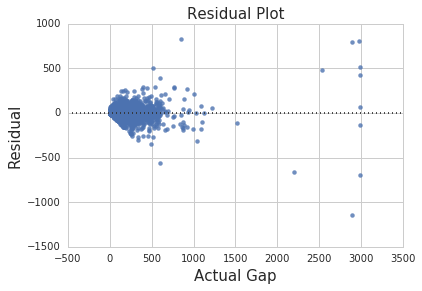

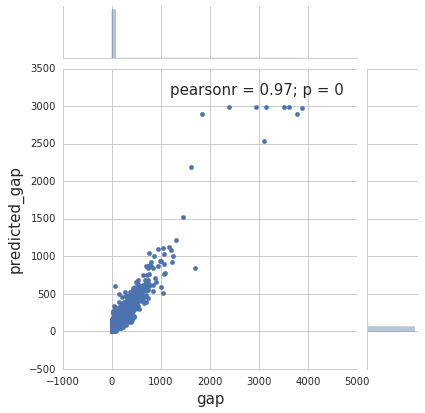

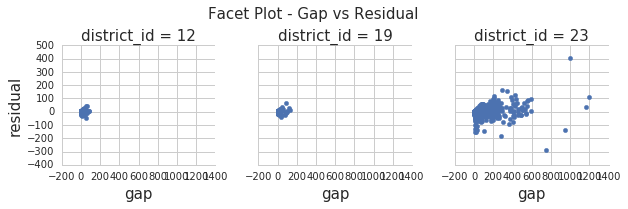

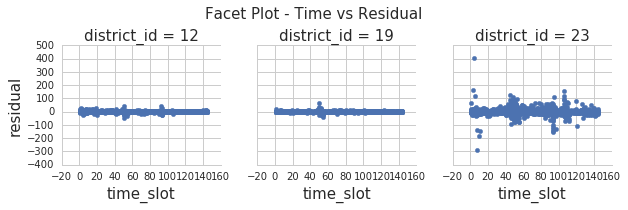

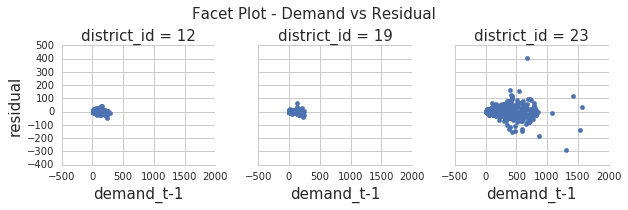

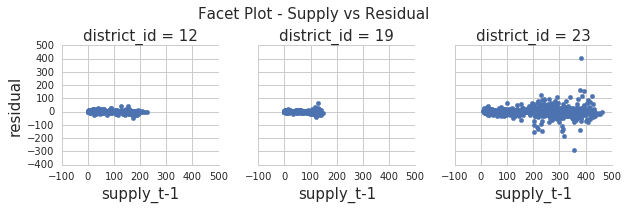

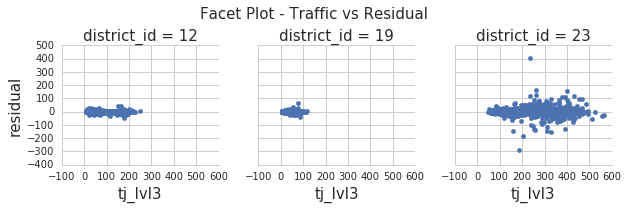

FEATURE IMPORTANCES - RESIDUAL vs SELECT FEATURES
 1) time_slot                      0.364788
 2) week_day                       0.102400
 3) wthr_0                         0.085857
 4) numday_3                       0.057152
 5) wthr_1                         0.049427
 6) poi_pc2                        0.045194
 7) poi_pc4                        0.043605
 8) weekday_1                      0.042146
 9) numday_2                       0.025881
10) poi_pc3                        0.025758
11) numday_0                       0.024673
12) wthr_2                         0.024505
13) numday_1                       0.020992
14) weekday_2                      0.017879
15) weekday_0                      0.016957
16) dist_5                         0.010639
17) wthr_3                         0.010286
18) dist_2                         0.009693
19) dist_4                         0.009269
20) dist_3                         0.005198
21) dist_0                         0.004293
22) dist_1                

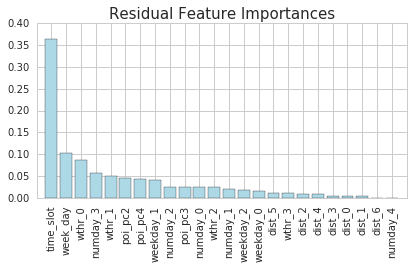

In [11]:
rf_predictors = [0,1,6,7,25,26,27,28]

regressor = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=11, max_features=1.0, max_leaf_nodes=None, 
                                  min_samples_leaf=5, min_samples_split=15, min_weight_fraction_leaf=0.0, 
                                  n_estimators=300, n_jobs=-1, oob_score=False, random_state=0, verbose=0, 
                                  warm_start=False)

random_forests_residual = ResidualPlot(regressor, gX_train[:, rf_predictors], gy_train)
random_forests_residual.generate_corrmatrix()
random_forests_residual.generate_resplot()
random_forests_residual.generate_facetplots()
random_forests_residual.feature_importances()

## Analysis
* **Linear correlation**     
  Besides the expected correlation with gap and demand, the residual does not exhibit any significant correlation with other features.
* **Feature importances**    
  The original (non-binary) time_slot, week_day features exhibit a significant non-linear relationship to the residual.
* **Plots**    
  * The time_slot plot (district_id=23) indicates some non-linear relationship with the residual. My inference is that this information was not captured by the algorithm.

## GRADIENT BOOSTED TREES

Successfully fit the algorithm to train data.
Generated predictions and errors for train data.
Created dataframe with residual column.

CORRELATION MATRIX - RESIDUAL vs FEATURES
district_id     -0.003567
num_day         -0.006705
time_slot        0.000529
week_day        -0.003167
demand           0.102212
demand_t-1       0.004477
demand_t-2       0.002800
demand_t-3       0.003090
supply           0.011344
supply_t-1       0.005975
supply_t-2       0.002701
supply_t-3       0.002616
gap              0.209822
weather          0.003715
temperature     -0.001135
pollution        0.007928
poi_pc1         -0.004115
poi_pc2          0.004448
poi_pc3          0.010418
poi_pc4          0.010164
poi_cluster      0.002430
tj_lvl1          0.002559
tj_lvl2          0.002526
tj_lvl3          0.004835
tj_lvl4          0.004046
gap_t-1          0.000079
gap_t-2          0.001773
gap_t-3          0.002562
predicted_gap    0.065500
residual         1.000000
Name: residual, dtype: float64


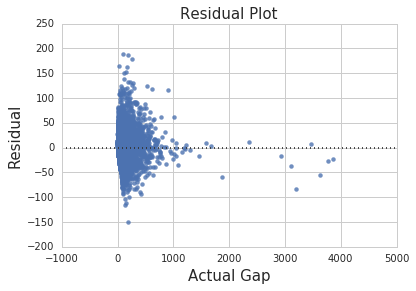

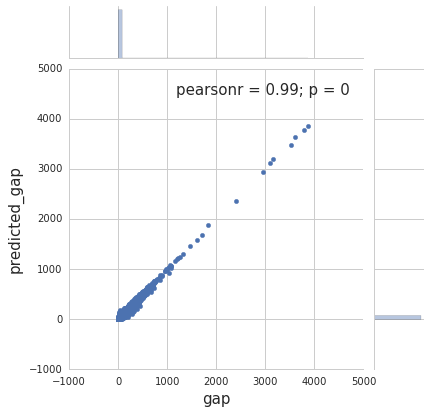

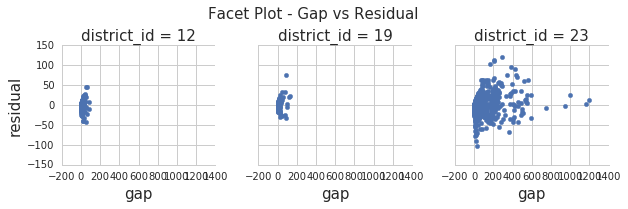

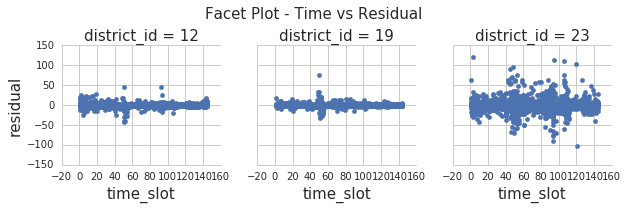

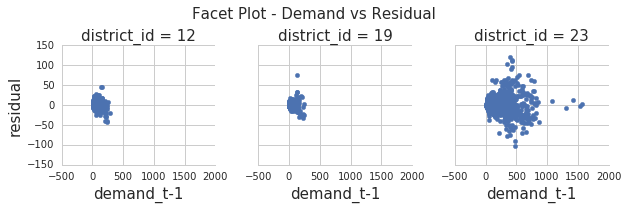

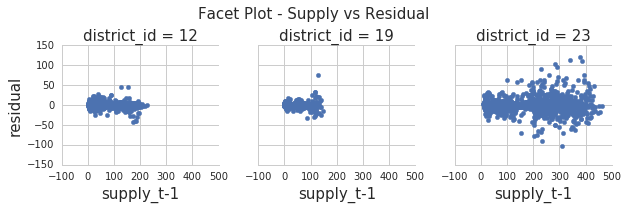

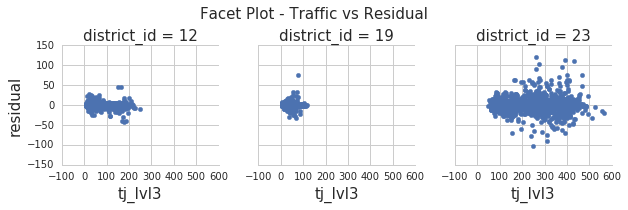

FEATURE IMPORTANCES - RESIDUAL vs SELECT FEATURES
 1) time_slot                      0.436940
 2) week_day                       0.110256
 3) numday_3                       0.048339
 4) numday_0                       0.040011
 5) poi_pc4                        0.034699
 6) poi_pc2                        0.033399
 7) numday_1                       0.033080
 8) weekday_0                      0.031110
 9) poi_pc3                        0.028931
10) wthr_0                         0.024238
11) numday_2                       0.023795
12) weekday_1                      0.021996
13) wthr_1                         0.021794
14) wthr_2                         0.021379
15) wthr_3                         0.017222
16) weekday_2                      0.015112
17) dist_5                         0.014132
18) dist_3                         0.010200
19) dist_0                         0.009706
20) dist_4                         0.008159
21) dist_1                         0.008066
22) dist_2                

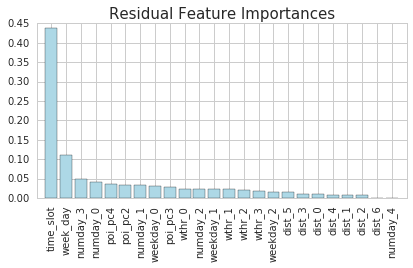

In [12]:
gbr_predictors = [0,1,2,8,9,10,25,26,27,28,29,30]

regressor = GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',max_depth=5, max_features=None, 
                                      max_leaf_nodes=None, min_samples_leaf=3, min_samples_split=6, 
                                      min_weight_fraction_leaf=0.0, n_estimators=200, presort='auto', random_state=None, 
                                      subsample=1.0, verbose=0, warm_start=False)

gbr_residual = ResidualPlot(regressor, gX_train[:, gbr_predictors], gy_train)
gbr_residual.generate_corrmatrix()
gbr_residual.generate_resplot()
gbr_residual.generate_facetplots()
gbr_residual.feature_importances()

## Analysis
* **Linear correlation**     
  Besides the expected correlation with gap and demand, the residual does not exhbit correlation with any other features.
* **Feature importances**    
  The original (non-binary) time_slot, week_day features exhibit a significant non-linear relationship to the residual.
* **Plots**    
  * The time_slot plot (district_id=23) indicates some non-linear relationship with the residual. My inference is that this information was not captured by the algorithm.

## NEURAL NETS

Successfully fit the algorithm to train data.
Generated predictions and errors for train data.
Created dataframe with residual column.

CORRELATION MATRIX - RESIDUAL vs FEATURES
district_id     -0.013797
num_day         -0.008931
time_slot       -0.002180
week_day         0.002254
demand           0.123375
demand_t-1      -0.001284
demand_t-2       0.002703
demand_t-3       0.006447
supply          -0.015259
supply_t-1      -0.010424
supply_t-2      -0.008401
supply_t-3      -0.002712
gap              0.301411
weather         -0.002492
temperature     -0.008128
pollution        0.012037
poi_pc1          0.007583
poi_pc2         -0.006735
poi_pc3          0.027265
poi_pc4          0.009120
poi_cluster      0.004709
tj_lvl1          0.000451
tj_lvl2         -0.007716
tj_lvl3         -0.006889
tj_lvl4         -0.003648
gap_t-1          0.014468
gap_t-2          0.020035
gap_t-3          0.018953
predicted_gap    0.012010
residual         1.000000
Name: residual, dtype: float64


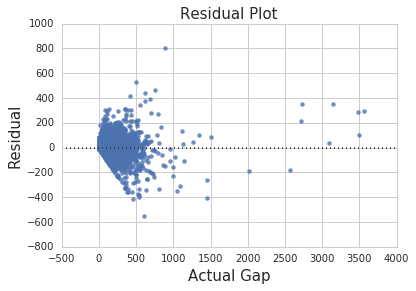

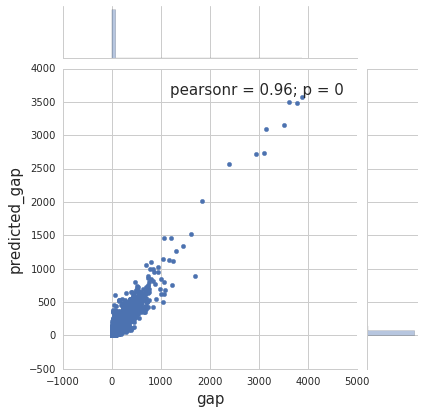

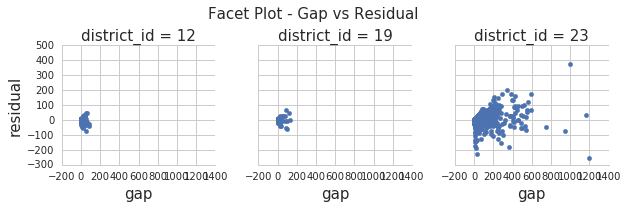

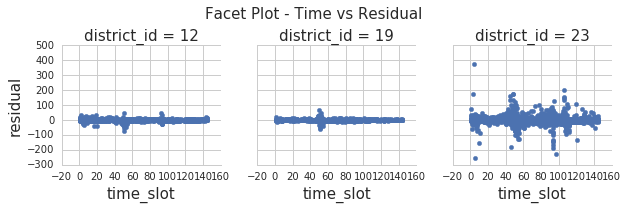

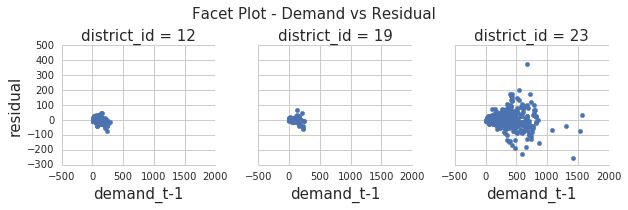

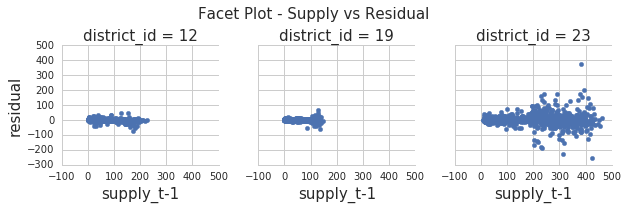

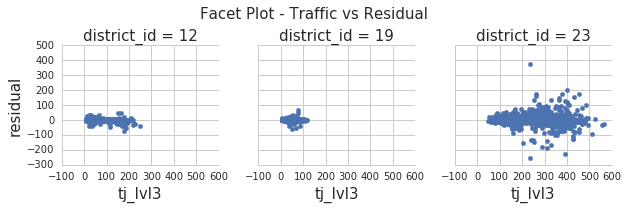

FEATURE IMPORTANCES - RESIDUAL vs SELECT FEATURES
 1) time_slot                      0.408632
 2) week_day                       0.136936
 3) poi_pc4                        0.058597
 4) numday_3                       0.049777
 5) numday_0                       0.033719
 6) wthr_0                         0.032811
 7) poi_pc2                        0.030684
 8) numday_1                       0.030333
 9) poi_pc3                        0.027994
10) numday_2                       0.027642
11) wthr_1                         0.026673
12) wthr_2                         0.024691
13) weekday_0                      0.023153
14) weekday_1                      0.022822
15) weekday_2                      0.015772
16) wthr_3                         0.013586
17) dist_4                         0.008262
18) dist_3                         0.007558
19) dist_2                         0.006285
20) dist_0                         0.005948
21) dist_5                         0.005361
22) dist_1                

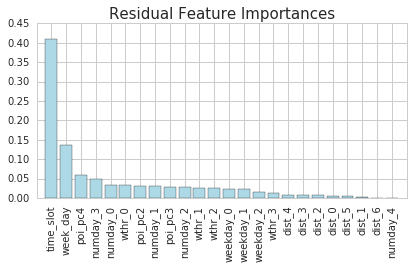

In [13]:
nn_predictors = [0,1,2,6,7,8,9,10,25,26,28,29]

# Set up optimizer, regressor
learning_rate=0.03 
hidden_units=[12, 12, 12] 
dropout=0.01 
steps=10000 
batch_size=3000

optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
alg = skflow.DNNRegressor(hidden_units=hidden_units, optimizer=optimizer, dropout=float(dropout))

nn_residual = ResidualPlotnn(alg, gX_train[:, nn_predictors], gy_train, steps, batch_size)
nn_residual.generate_corrmatrix()
nn_residual.generate_resplot()
nn_residual.generate_facetplots()
nn_residual.feature_importances()

## Analysis
* **Linear correlation**     
  Besides the expected correlation with gap & demand, the residual does not exhibit correlation with any other features.
* **Feature importances**    
  The original (non-binary) time_slot, week_day features exhibit a significant non-linear relationship to the residual.
* **Plots**    
  * The time_slot plot (district_id=23) indicates some non-linear relationship with the residual. My inference is that this information was not captured by the algorithm.

## ENSEMBLE - RF, GB & NN

Generated predictions and errors for train data.
Created dataframe with residual column.

CORRELATION MATRIX - RESIDUAL vs FEATURES
district_id     -0.008202
num_day         -0.009641
time_slot       -0.002132
week_day        -0.000866
demand           0.149915
demand_t-1       0.021408
demand_t-2       0.008447
demand_t-3       0.000731
supply           0.000939
supply_t-1       0.003805
supply_t-2       0.002632
supply_t-3       0.006486
gap              0.333854
weather          0.001185
temperature     -0.003438
pollution        0.010561
poi_pc1         -0.001097
poi_pc2          0.001412
poi_pc3          0.016359
poi_pc4          0.007567
poi_cluster      0.003207
tj_lvl1          0.002955
tj_lvl2          0.000594
tj_lvl3          0.003669
tj_lvl4          0.005669
gap_t-1          0.041579
gap_t-2          0.014530
gap_t-3         -0.009165
predicted_gap    0.128213
residual         1.000000
Name: residual, dtype: float64


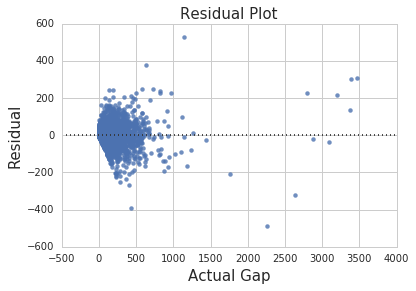

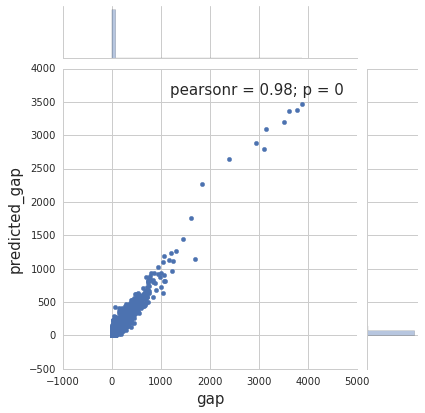

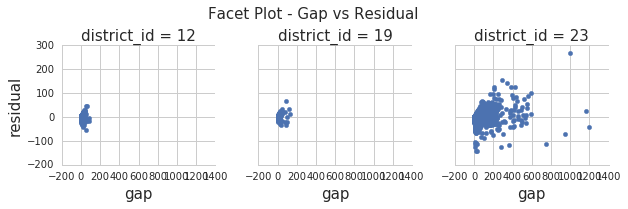

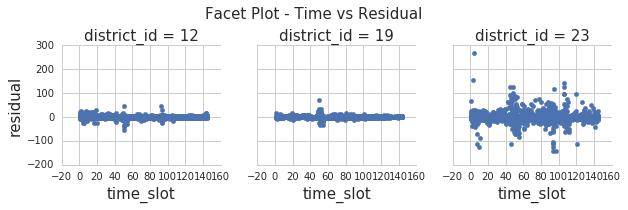

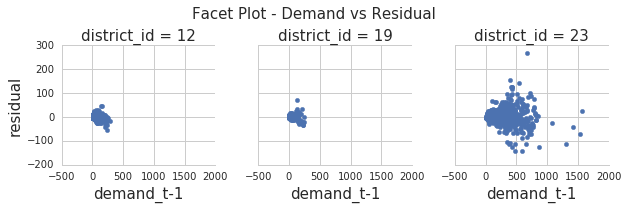

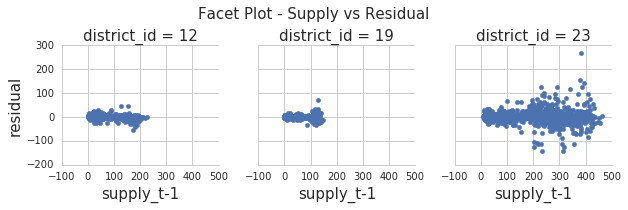

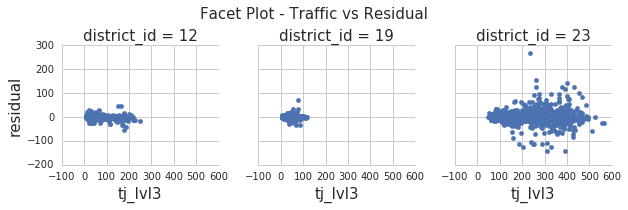

FEATURE IMPORTANCES - RESIDUAL vs SELECT FEATURES
 1) time_slot                      0.399093
 2) week_day                       0.121346
 3) numday_3                       0.054605
 4) poi_pc4                        0.049171
 5) wthr_0                         0.042130
 6) poi_pc2                        0.037060
 7) numday_0                       0.033653
 8) wthr_1                         0.029914
 9) poi_pc3                        0.029723
10) numday_1                       0.028678
11) weekday_1                      0.026872
12) numday_2                       0.024981
13) wthr_2                         0.024439
14) weekday_0                      0.023684
15) weekday_2                      0.015886
16) wthr_3                         0.014564
17) dist_5                         0.009750
18) dist_4                         0.008478
19) dist_2                         0.007938
20) dist_3                         0.007927
21) dist_0                         0.005943
22) dist_1                

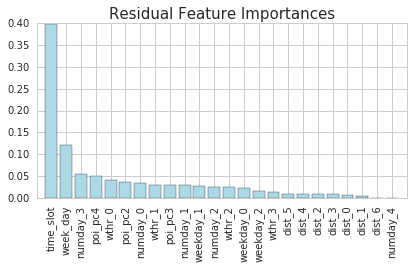

In [16]:
rf_trainpred  = random_forests_residual.pred_train
gbr_trainpred = gbr_residual.pred_train
nn_trainpred  = nn_residual.pred_train

train_prediction = (rf_trainpred + gbr_trainpred + nn_trainpred) / 3.0

en_residual = ResidualPloten(train_prediction)
en_residual.generate_corrmatrix()
en_residual.generate_resplot()
en_residual.generate_facetplots()
en_residual.feature_importances()

## Analysis
* **Linear correlation**     
  Besides the expected correlation with gap & demand, the residual does not exhibit correlation with any other features.
* **Feature importances**    
  The original (non-binary) time_slot, week_day features exhibit a significant non-linear relationship to the residual.
* **Plots**    
  * The time_slot plot (district_id=23) indicates some non-linear relationship with the residual. My inference is that this information was not captured by the algorithm.